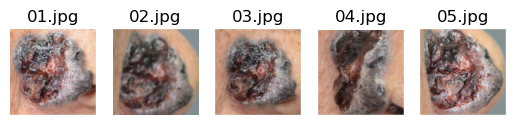

In [2]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import cv2
import numpy as np

image_paths = sorted(Path('src').glob('*'))
images = [Image.open(p).convert('RGB') for p in image_paths]

fig, axs = plt.subplots(1, 5, squeeze=True)
for i in range(len(axs)):
    image_path = image_paths[i]
    axs[i].set_title(f"{image_path.name}")
    axs[i].imshow(images[i])
    axs[i].axis('off')
plt.show()

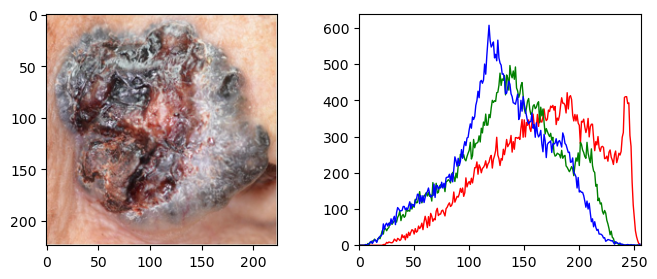

In [3]:
image = Image.open(image_paths[0]).convert('RGB')
image = image.resize((224,224))
image = TF.pil_to_tensor(image).permute(1,2,0)

R = cv2.calcHist([np.array(image)], [0], None, [256], [0, 256])
G = cv2.calcHist([np.array(image)], [1], None, [256], [0, 256])
B = cv2.calcHist([np.array(image)], [2], None, [256], [0, 256])

fig, axs = plt.subplots(1,2, figsize=(8,3))
axs[0].imshow(image)
axs[1].plot(R, lw=1, c='red')
axs[1].plot(G, lw=1, c='green')
axs[1].plot(B, lw=1, c='blue')
axs[1].set_xlim(0, 256)
axs[1].set_ylim(0)
plt.show()

In [4]:
transform = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
])

X = [transform(image).unsqueeze(0) for image in images]
x = X[0]
print(f"{x.shape = }")

proj = nn.Conv2d(3, 768, 16, 16)
x = proj(x)
print(f"{x.shape = }") # patchsize x n_patches x n_patches = (3x16x16) x 14 x 14

x = x.flatten(2)
print(f"{x.shape = }") # sequence length of 196, embedded into 768 dimension. We are gonna need an additional <cls> token in the very front.

x.shape = torch.Size([1, 3, 224, 224])
x.shape = torch.Size([1, 768, 14, 14])
x.shape = torch.Size([1, 768, 196])


https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
### Positional encoding

$f : \mathbb N \to \mathbb R^d$ \
$\omega_k = \dfrac{1}{10000^{2k/d}}$ \
$d \equiv_2 0$

$$
\begin{align*}

\mathbf p^{<t>} &= f(t) \coloneqq
\begin{cases}
\sin(\omega_k \cdot t), \quad \text{if } i = 2k \\
\cos(\omega_k \cdot t), \quad \text{if } i = 2k +  1 \\
\end{cases} \\[20pt]

\mathbf p^{<t>} &=
\begin{bmatrix}
\sin(\omega_1 \cdot t) \\
\cos(\omega_1 \cdot t) \\
\\
\sin(\omega_2 \cdot t) \\
\cos(\omega_2 \cdot t) \\
\\
\vdots \\
\\
\sin(\omega_{d/2} \cdot t) \\
\cos(\omega_{d/2} \cdot t) \\
\end{bmatrix}_{d \times 1}

\end{align*}
$$

dim  = 768
time = 197


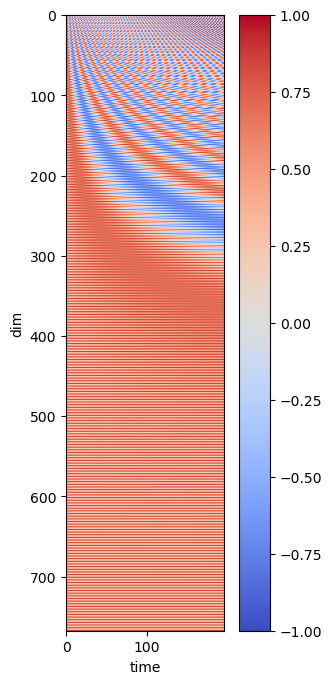

In [5]:
_, dim, time = x.shape

time += 1 # <cls> token
dim = dim if dim % 2 == 0 else dim + 1 # dim should be an even number

print(f"{dim  = }")
print(f"{time = }")

Time  = torch.arange(0, time)
Dim   = torch.arange(1, dim//2 + 1)
Omega = 1 / (100000**(2*Dim/dim))
Time_Omega = torch.outer(Time, Omega)

positional_encoding = torch.stack([Time_Omega.sin(), Time_Omega.cos()], dim=2)
positional_encoding = positional_encoding.flatten(1)

plt.figure(figsize=(4,8))
plt.imshow(positional_encoding.T, cmap='coolwarm')
plt.xlabel('time')
plt.ylabel('dim')
plt.colorbar(orientation='vertical')
plt.show()

In [6]:
x = [transform(img) for img in images]
x = torch.stack(x)
x.shape

torch.Size([5, 3, 224, 224])

In [7]:
conv = nn.Conv2d(in_channels=3, out_channels=3*16*16, kernel_size=16, stride=16)
conv(x).flatten(2).shape

torch.Size([5, 768, 196])

In [20]:
from CrossViT.models import crossvit

pe = crossvit.PatchEmbed()
pe(x).shape

torch.Size([5, 196, 768])